<h1><center> PEMODELAN DAN PERAMALAN DERET WAKTU</center></h1><center>Nabila Syukri - M0501241086 </center>

<center>
_____________________________________________________________________________________________________________________________
</center>



Lakukan Pemodelan hingga peramalan untuk deret waktu harga bulanan satu barel minyak mentah dari Januari 1986 sampai Januari 2006. Data dapat diakses dengan sintaks sebagai berikut.

- Setiap individu menambah data dengan angka berupa 2 kali dari dua digit terakhir NIM, misal digit terakhir NIM 07, maka setiap baris dari data ditambah dengan $2 \times 7=14$

- Lakukan pembagian data latih dan data uji untuk pemodelan (pembagian data mengikuti pola dari data, bukan berdasarkan proporsi)

- Hitung nilai kebaikan model berdasarkan MAPE pada data uji

**Langkah-Langkah**
1. Membagi data Training Testing
2. Eksplorasi
3. Cek Stastioner
4. Differencing
5. Cek nilai lambda = 1
6. Data stasioner -> Plot ACF PACF
7. Identifikasi Model tentatif
8. Cek Diagnostik masing-masing model
9. Memilih model terbaik berdasarkan AIC, BIC
10. Overfitting
11. Forecasting
12. Akurasi Model dengan MAPE

In [554]:
!pip install PythonTsa

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from scipy.stats import boxcox,  boxcox_llf

import warnings
warnings.filterwarnings("ignore")

In [556]:
link = "http://homepage.divms.uiowa.edu/~kchan/TSA/Datasets/oil.price.dat"
oil=pd.read_csv(link,delimiter='\t')
oil.columns=['minyak']

menambahkan konstanta 172

Nim 2 digit terakhir adalah 86 --> 86 x 2 = 172

In [557]:
oil['minyak'] = oil['minyak'] + 172

In [558]:
oil['date'] = pd.date_range(start='1986-01-01', end='2006-01-01', freq='MS')

In [559]:
oil.head(10)

,minyak,date
0,194.93,1986-01-01
1,187.45,1986-02-01
2,184.61,1986-03-01
3,184.84,1986-04-01
4,187.38,1986-05-01
5,185.43,1986-06-01
6,183.58,1986-07-01
7,187.10,1986-08-01
8,186.87,1986-09-01
9,186.90,1986-10-01


In [560]:
oil.tail(20)

,minyak,date
221,210.02,2004-06-01
222,212.78,2004-07-01
223,216.90,2004-08-01
224,217.94,2004-09-01
225,225.28,2004-10-01
226,220.47,2004-11-01
227,215.15,2004-12-01
228,218.84,2005-01-01
229,220.15,2005-02-01
230,226.19,2005-03-01


In [561]:
oil = oil[['date', 'minyak']]

In [562]:
oil.dtypes

,0
date,datetime64[ns]
minyak,float64


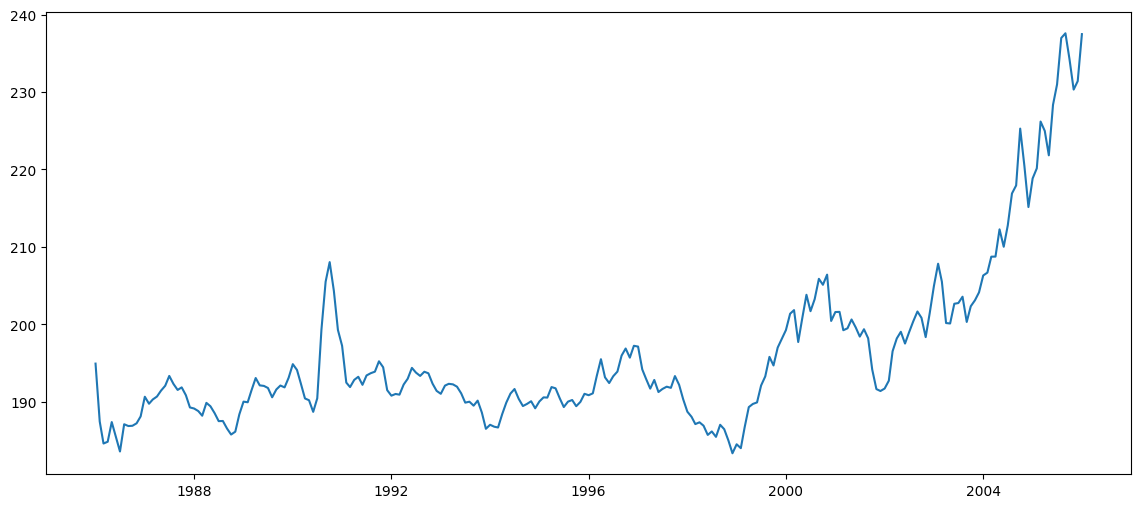

In [563]:
plt.figure(figsize=(14,6))
plt.plot(oil.date, oil.minyak); # Specify 'date' for the x-axis
plt.show()

# Splitting Data

In [564]:
train = oil[:230]  # 230 baris pertama adalah data training
test = oil[230:]  # selainnya adah data testing

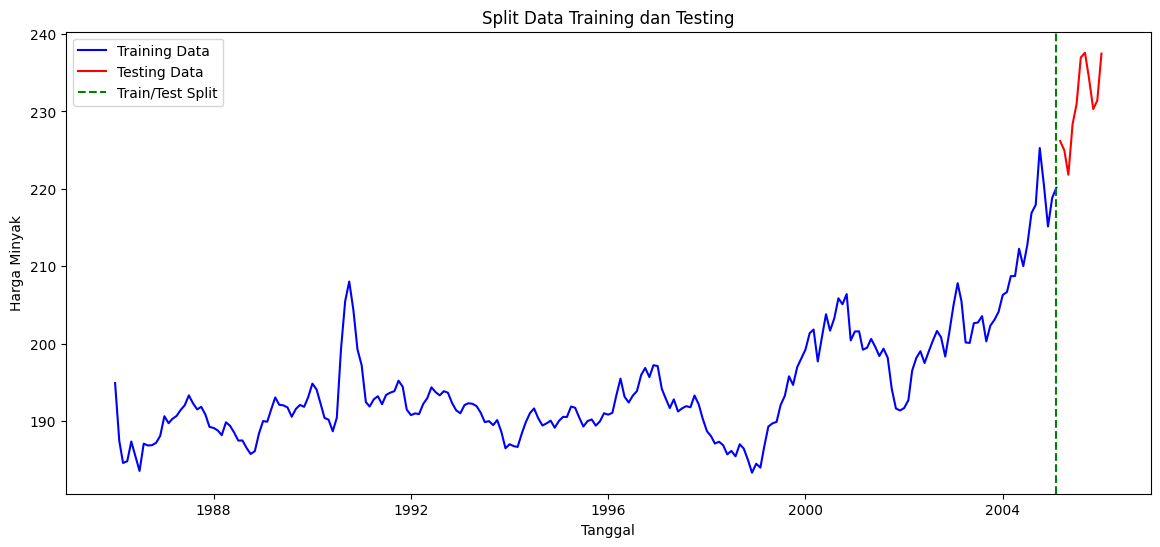

In [565]:

plt.figure(figsize=(14,6))
plt.plot(oil.date[:230], oil.minyak[:230], color='blue', label='Training Data')  # Plot training data in blue
plt.plot(oil.date[230:], oil.minyak[230:], color='red', label='Testing Data')  # Plot testing data in red
plt.axvline(x=oil.date[229], color='green', linestyle='--', label='Train/Test Split') # Add vertical line to mark split point

plt.xlabel("Tanggal")
plt.ylabel("Harga Minyak")
plt.title("Split Data Training dan Testing")
plt.legend()
plt.show()


In [566]:
train = pd.DataFrame(train)
train

,date,minyak
0,1986-01-01,194.93
1,1986-02-01,187.45
2,1986-03-01,184.61
3,1986-04-01,184.84
4,1986-05-01,187.38
...,...,...
225,2004-10-01,225.28
226,2004-11-01,220.47
227,2004-12-01,215.15
228,2005-01-01,218.84


In [567]:
test = pd.DataFrame(test)  # Assuming 'minyak' is the original column name
test

,date,minyak
230,2005-03-01,226.19
231,2005-04-01,224.98
232,2005-05-01,221.83
233,2005-06-01,228.35
234,2005-07-01,230.99
235,2005-08-01,236.98
236,2005-09-01,237.59
237,2005-10-01,234.26
238,2005-11-01,230.32
239,2005-12-01,231.41


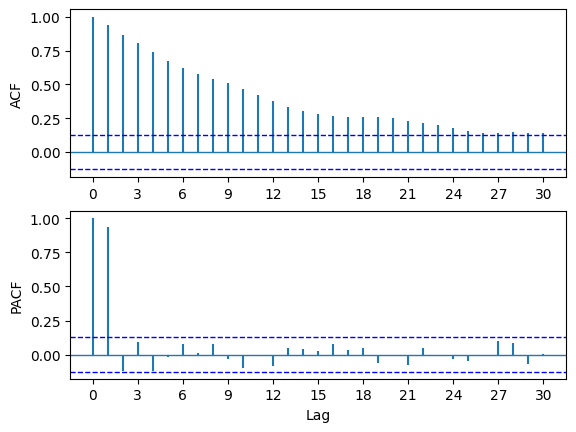

In [568]:
#plot acf dan pacf contoh
acf_pacf_fig(train.minyak, both=True, lag=30); plt.show()

Berdasarkan plot ACF menunjukkan data training tidak stasioner terhadap nilai tengah karena penurunan secara melambat (tail off)

In [569]:
from statsmodels.tsa.stattools import adfuller
adfuller(train.minyak, autolag='AIC')[1]

0.9440630367876226

Nilai ADF membuktikan pernyataan di atas terkait ketidakstasioneran nilai tengah dengan p-value lebih besar dari 0.05 sehingga menunjukkan data tidak stasioner terhadap nilai tengah --> Lakukan diferencing

# Stasioneritas

In [570]:
#Differencing
minyak_diff=train.minyak.diff().dropna()

In [571]:
# Create a new DataFrame for Net_diff
train_diff = pd.DataFrame({'minyak_diff': minyak_diff})
train_diff


,minyak_diff
1,-7.48
2,-2.84
3,0.23
4,2.54
5,-1.95
...,...
225,7.34
226,-4.81
227,-5.32
228,3.69


In [572]:
len(train_diff)

229

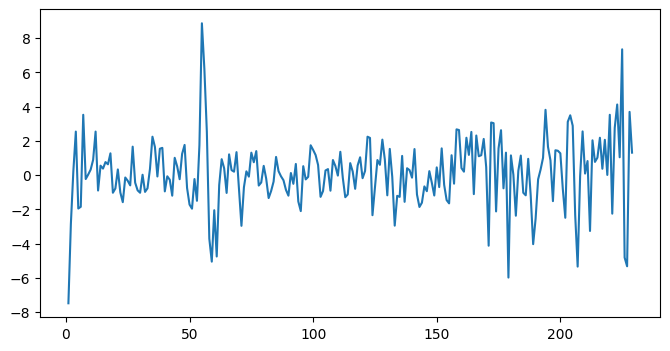

In [573]:
plt.figure(figsize=(8,4))
plt.plot(train_diff)
plt.show()

Plot hasil differencing terlihat stasioner terhadap nilai tengah, selanjutnya kita cek dengan plot ACF dan uji ADF

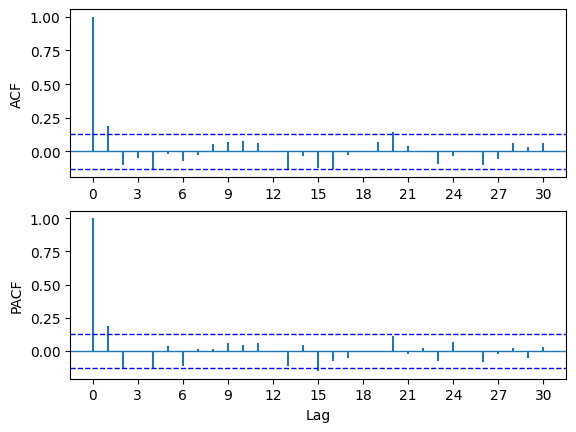

In [574]:
acf_pacf_fig(train_diff, both=True, lag=30); plt.show()

berdasarkan plot ACF cut off sehingga data sudah stasioner terhadap nilai tengah

In [575]:
adfuller(train_diff.minyak_diff, autolag='AIC')[1]

3.2692396420333327e-14

berdasarkan nilai ADF < 0.05 sehingga terbukti bahwa data stasioner terhadap nilai tengah

Selanjutnya cek kestasioneran terhadap ragam dengan melihat nilai lambda. Namun sebelum itu perlu dilakukan penambahan konstanta karena transformasi boxcox tidak boleh memuat nilai negatif dan nol

In [576]:
from scipy.stats import boxcox,  boxcox_llf
# Assuming min_value is the minimum value in Net_diff column + 1
train_diff['minyak_diff_shifted'] = train_diff['minyak_diff'] + abs(train_diff['minyak_diff'].min()) + 1

In [577]:
train_diff['minyak_diff_shifted']

,minyak_diff_shifted
1,1.00
2,5.64
3,8.71
4,11.02
5,6.53
...,...
225,15.82
226,3.67
227,3.16
228,12.17


In [578]:
from scipy.stats import boxcox,  boxcox_llf
data,lambda_fit,ci=boxcox(train_diff.minyak_diff_shifted, alpha=0.05)

print(f'nilai lambda: ',lambda_fit)
print(f'interval kepercayaan lambda:', ci)

nilai lambda:  1.1277516414755795
interval kepercayaan lambda: (0.8537006910292553, 1.4172894128671234)


nilai lambda memuat 1 sehingga data telah stasioner terhadap ragam

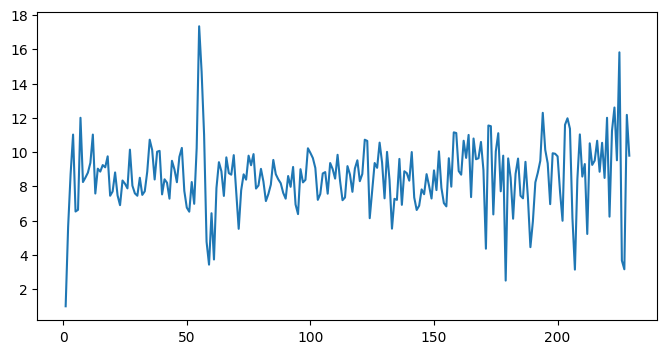

In [579]:
plt.figure(figsize=(8,4))
# Assuming the array holds this data
plt.plot(train_diff['minyak_diff_shifted'])
plt.show()

# Identifikasi Model
Setelah data stasioner terhadap nilai tengah dan ragam, selanjutnya identifikasi model

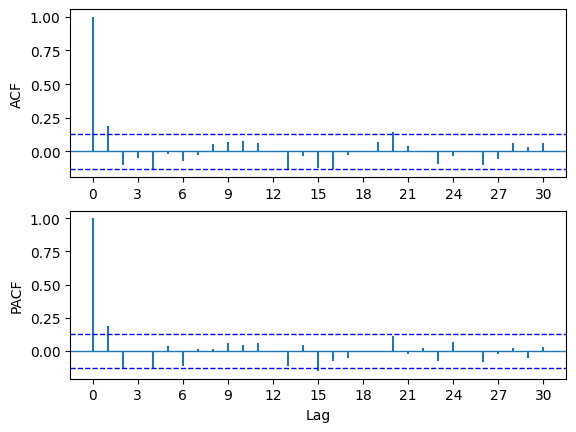

In [580]:
train_diff = pd.DataFrame(train_diff, columns=['minyak_diff'])
acf_pacf_fig(train_diff['minyak_diff'], both=True, lag=30)


Plot ACF menunjukkan cut off di lag 1 menandakan ada komponen MA (1).

 plot PACF cut off di lag 1 dan nyaris cut off di lag 2 sehingga ada komponen AR(2). Untuk memastikan di lag 2 signifikan atau tidak dilakukan uji statistik

In [581]:
from statsmodels.tsa.stattools import pacf

# Hitung ACF hingga lag 20
pacf_values = pacf(train_diff['minyak_diff'], nlags=3)

# Hitung batas kritis (CI) 95%
n = len(train_diff['minyak_diff'])
conf_interval = 1.96 / np.sqrt(n)

# Tampilkan lag yang keluar dari batas
for lag, value in enumerate(pacf_values):
    if abs(value) > conf_interval:
        print(f"Lag {lag}: Autocorrelation {value:.4f} (Signifikan)")

Lag 0: Autocorrelation 1.0000 (Signifikan)
Lag 1: Autocorrelation 0.1867 (Signifikan)
Lag 2: Autocorrelation -0.1403 (Signifikan)


karena secara statistik terbukti PACF cut off di lag 1 dan 2 maka ada komponen AR(2)

Sehingga model tentatif yang akan diuji ialah

*   ARIMA (0,1,1)
*   ARIMA (1,1,0)
*   ARIMA (2,1,0)




## Model ARIMA (0,1,1)

In [582]:
#model MA (1)
model_ma1=ARIMA(train_diff,order=(0,0,1)).fit()

In [583]:
print(model_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:            minyak_diff   No. Observations:                  229
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -477.241
Date:                Sun, 09 Mar 2025   AIC                            960.482
Time:                        15:36:08   BIC                            970.783
Sample:                             0   HQIC                           964.638
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1024      0.160      0.639      0.523      -0.211       0.416
ma.L1          0.2606      0.042      6.233      0.000       0.179       0.343
sigma2         3.7805      0.223     16.915      0.0

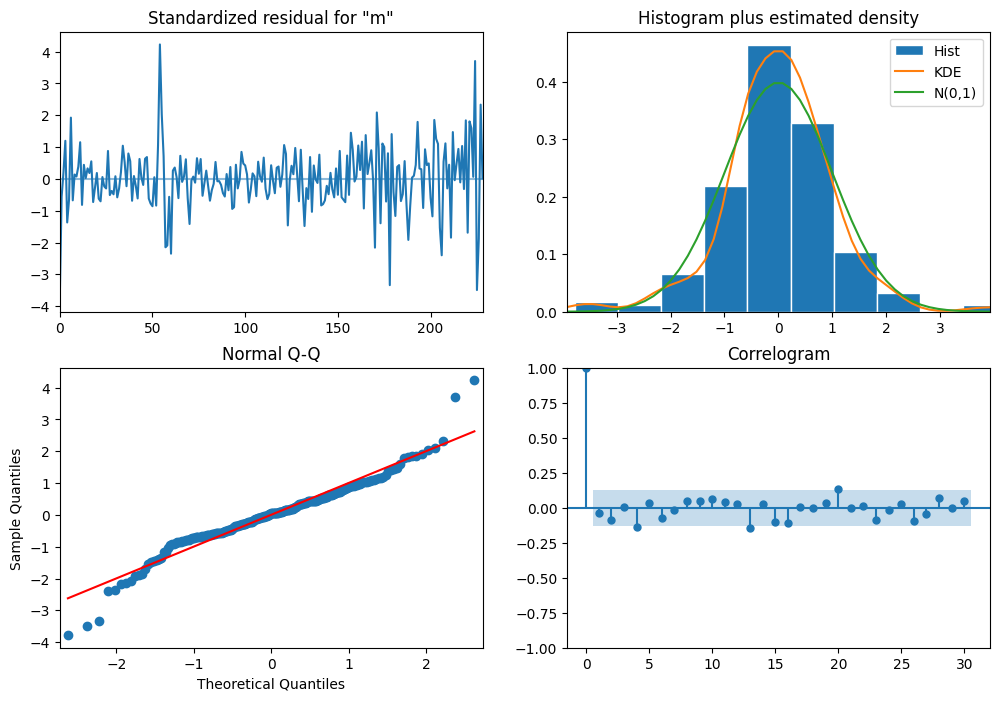

In [584]:
#Analisis Sisaan Model
model_ma1.plot_diagnostics(figsize=(12,8), lags=30)
plt.show()

In [585]:
model_ma1.test_heteroskedasticity('breakvar')

array([[1.60178859, 0.04159926]])

H₀ (Hipotesis Nol): Tidak ada heteroskedastisitas (varians residual konstan seiring waktu).

H₁ (Hipotesis Alternatif): Ada heteroskedastisitas (varians residual berubah seiring waktu).

berdasarkan uji Breakvar (p-value = 0.0416 < 0.05) sehingga ada heteroskedastisitas  → Varian residual berubah seiring waktu.

In [586]:
from statsmodels.sandbox.stats.runs import runstest_1samp
runstest_1samp(model_ma1.resid, correction=False)

(0.8759472866242592, 0.38105869121394664)

H₀ (Hipotesis Nol): Residual model bersifat acak (tidak ada pola sistematis dalam error).

H₁ (Hipotesis Alternatif): Residual model tidak acak (ada pola sistematis dalam error, yang menunjukkan kemungkinan autokorelasi).

karena p-value > alpha (0.381 > 0.05) sehingga tidak ada autokorelasi dakam sisaan model

In [587]:
from scipy.stats import shapiro
stat,p = shapiro(model_ma1.resid)
print(stat,p)

0.9530507272865811 8.629938747567793e-07


In [588]:
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(model_ma1.resid)
print(jb_stat, jb_pval)

91.38859449780439 1.4296141904453443e-20


H₀ (Hipotesis Nol): Residual model berdistribusi normal.

H₁ (Hipotesis Alternatif): Residual model tidak berdistribusi normal.

Karena p-value < alpha sehingga residual tidak berdistribusi normal. Namun dalam data time series yang memiliki amatan banyak sehingga berdasarkan dalil limit pusat diasumsikan residual berdistribusi normal

Model ARIMA (0,1,1) tidak memenuhi asumsi heteroskedastisitas sehingga tidak diikutkan dalam pemilihan model

## Model ARIMA(1,1,0)

In [589]:
#model AR (1)
model_ar1=ARIMA(train_diff,order=(1,0,0)).fit()

In [590]:
print(model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:            minyak_diff   No. Observations:                  229
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -478.636
Date:                Sun, 09 Mar 2025   AIC                            963.272
Time:                        15:36:09   BIC                            973.573
Sample:                             0   HQIC                           967.428
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1033      0.159      0.648      0.517      -0.209       0.416
ar.L1          0.1980      0.044      4.525      0.000       0.112       0.284
sigma2         3.8273      0.228     16.808      0.0

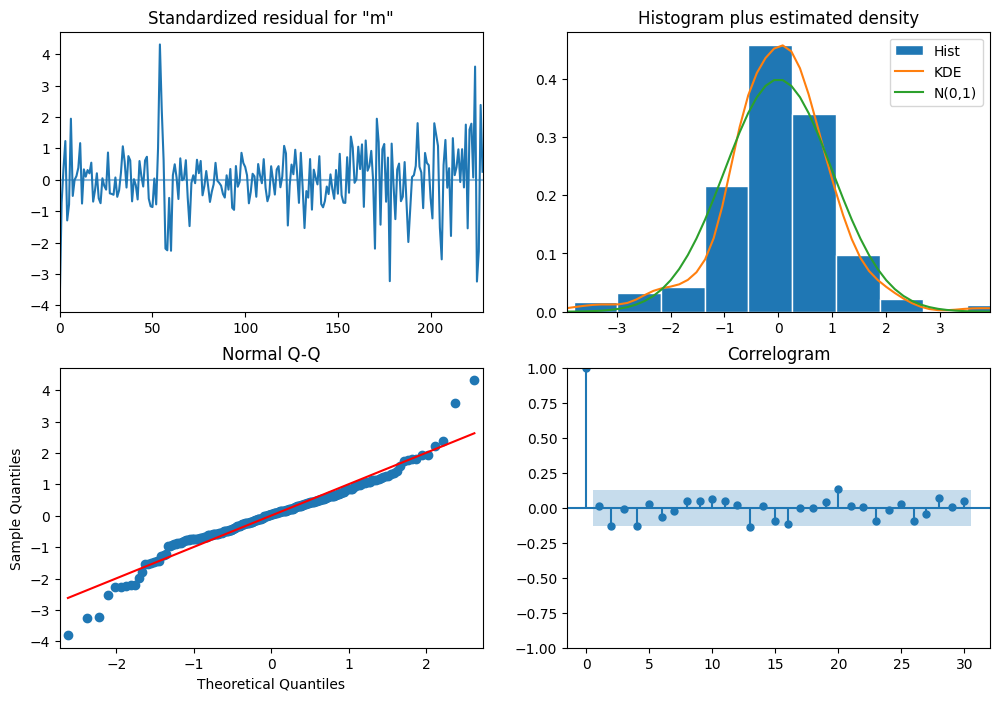

In [591]:
#Analisis Sisaan Model
model_ar1.plot_diagnostics(figsize=(12,8), lags=30)
plt.show()

In [592]:
model_ar1.test_heteroskedasticity('breakvar')

array([[1.52541034, 0.06757444]])

In [593]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_ar1.resid, nlags=30)[1]

0.11251893317990386

In [594]:
from statsmodels.sandbox.stats.runs import runstest_1samp
runstest_1samp(model_ar1.resid, correction=False)

(0.6204331929854164, 0.534972624877528)

In [595]:
from scipy.stats import shapiro
stat,p = shapiro(model_ar1.resid)
print(stat,p)

0.9538988769206798 1.0639369654980535e-06


In [596]:
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print(jb_stat, jb_pval)

86.35873586105286 1.7678229828146532e-19


Karena Model ARIMA (1,1,0) Memenuhi asumsi dari residual model sehingga diikutkan dalam pemilihan model

## Model ARIMA(2,1,0)

In [597]:
#model AR (2)
model_ar2=ARIMA(train_diff,order=(2,0,0)).fit()

In [598]:
print(model_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:            minyak_diff   No. Observations:                  229
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -476.337
Date:                Sun, 09 Mar 2025   AIC                            960.674
Time:                        15:36:12   BIC                            974.409
Sample:                             0   HQIC                           966.215
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1074      0.142      0.757      0.449      -0.170       0.385
ar.L1          0.2226      0.044      5.037      0.000       0.136       0.309
ar.L2         -0.1464      0.053     -2.788      0.0

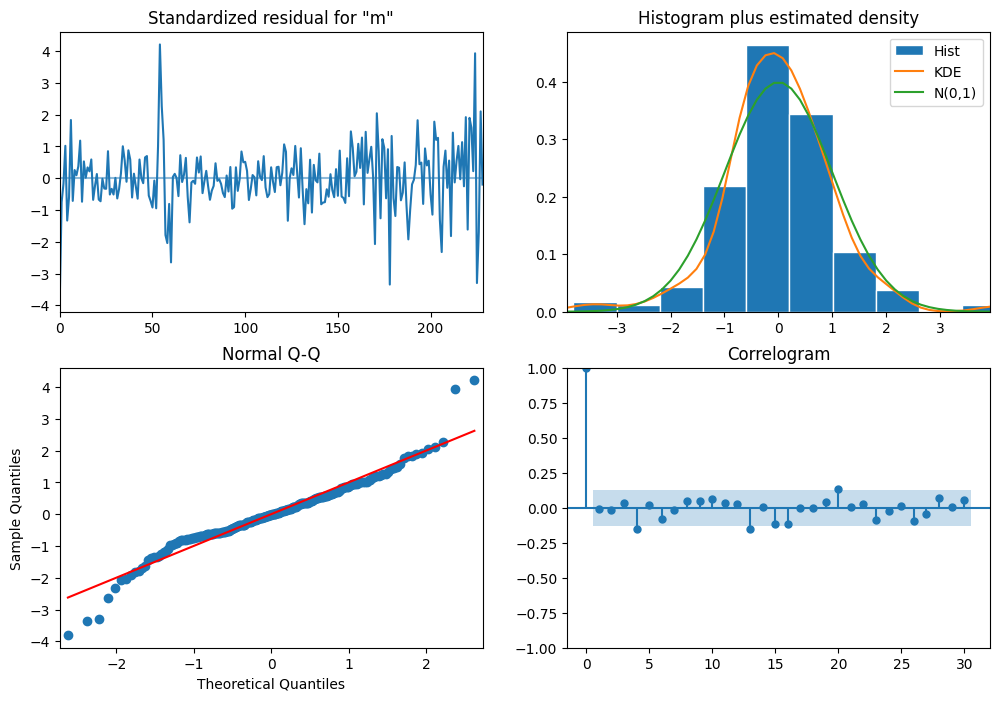

In [599]:
#Analisis Sisaan Model
model_ar2.plot_diagnostics(figsize=(12,8), lags=30)
plt.show()

In [600]:
model_ar2.test_heteroskedasticity('breakvar')

array([[1.54575973, 0.0594622 ]])

karena p-value > alpha sehingga terbukti memenuhi asumsi heteroskedastisitas

In [601]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_ar2.resid, nlags=30)[1]

0.1382130540932237

hal ini sejalan dengan het_arch yang lebih besar dari alpha sehingga memenui asumsi heteroskedastisitas

In [602]:
from statsmodels.sandbox.stats.runs import runstest_1samp
runstest_1samp(model_ar2.resid, correction=False)

(-0.06363540628770233, 0.9492605387229098)

p-value > alpha untuk uji asumsi autokorelasi sehingga memenuhi asumsi autokorelasi dalam residual model

In [603]:
from scipy.stats import shapiro
stat,p = shapiro(model_ar2.resid)
print(stat,p)

0.9543315080736018 1.1847869019754807e-06


In [604]:
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(model_ar2.resid)
print(jb_stat, jb_pval)

93.79810452412671 4.285489112507387e-21


H₀ (Hipotesis Nol): Residual model berdistribusi normal.

H₁ (Hipotesis Alternatif): Residual model tidak berdistribusi normal.

Karena p-value < alpha sehingga residual tidak berdistribusi normal. Namun dalam data time series yang memiliki amatan banyak sehingga berdasarkan dalil limit pusat diasumsikan residual berdistribusi normal

In [605]:
pd.DataFrame({'Model':['ARIMA(1,1,0)','ARIMA(2,1,0)'],
            'AIC':[model_ar1.aic,model_ar2.aic],
            'BIC':[model_ar1.bic,model_ar2.bic],
            'HQIC':[model_ar1.hqic,model_ar2.hqic] })

,Model,AIC,BIC,HQIC
0,"ARIMA(1,1,0)",963.272192,973.573358,967.427938
1,"ARIMA(2,1,0)",960.674257,974.409145,966.215252


Berdasarkan nilai AIC dan HQIC dari pemilihan model tentatif, model terbaik ialah model ARIMA(2,1,0)

# **Overfitting**

Model yang dilakukan overfitting


*   ARIMA (3,1,0)
*   ARIMA (2,1,1)



## Model ARIMA (3,1,0)

In [606]:
#model ARIMA (3,1,0)
model_ma3=ARIMA(train_diff,order=(3,0,0)).fit()

In [607]:
print(model_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:            minyak_diff   No. Observations:                  229
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -476.335
Date:                Sun, 09 Mar 2025   AIC                            962.670
Time:                        15:36:14   BIC                            979.839
Sample:                             0   HQIC                           969.596
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1076      0.148      0.727      0.467      -0.183       0.398
ar.L1          0.2220      0.044      5.013      0.000       0.135       0.309
ar.L2         -0.1454      0.055     -2.667      0.0

Hasil fitting model AR (3) memberikan hasil bahwa penduga parameter untuk komponen AR yaitu $(\phi_3)$ tidak signifikan, sehingga model AR (3) tidak lebih baik daripada model AR (2).

## Model arima (2,1,1)

In [608]:
#Model ARIMA(2,1,1)
model_arma21=ARIMA(train_diff,order=(2,0,1)).fit()

In [609]:
print(model_arma21.summary())

                               SARIMAX Results                                
Dep. Variable:            minyak_diff   No. Observations:                  229
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -475.656
Date:                Sun, 09 Mar 2025   AIC                            961.313
Time:                        15:36:17   BIC                            978.481
Sample:                             0   HQIC                           968.239
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1155      0.128      0.903      0.367      -0.135       0.366
ar.L1          0.8385      0.195      4.293      0.000       0.456       1.221
ar.L2         -0.2511      0.047     -5.302      0.0

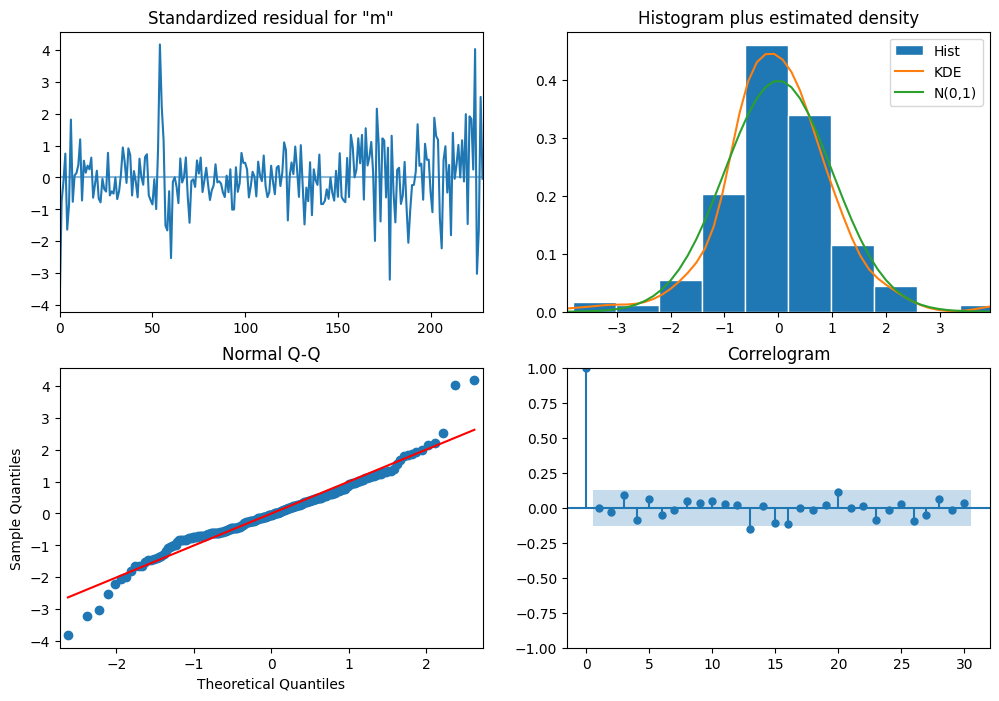

In [610]:
#Analisis Sisaan Model
model_arma21.plot_diagnostics(figsize=(12,8), lags=30)
plt.show()

In [611]:
model_arma21.test_heteroskedasticity('breakvar')

array([[1.64828412, 0.03076981]])

p-value < alpha sehingga tidak memenuhi asumsi heteroskedastisitas

In [612]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_arma21.resid, nlags=30)[1]

0.17431260328643797

In [613]:
from statsmodels.sandbox.stats.runs import runstest_1samp
runstest_1samp(model_arma21.resid, correction=False)

(-0.5890973193344785, 0.555795991555449)

asumsi autokorelasi terpenuhi karena p-value > alpha

In [614]:
from scipy.stats import shapiro
stat,p = shapiro(model_arma21.resid)
print(stat,p)

0.9586167636794969 3.548001922573927e-06


In [615]:
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(model_arma21.resid)
print(jb_stat, jb_pval)

85.21809715317124 3.1269815877326768e-19


Asumsi normalitas tidak terpenuhi tapi jika didekati dengan teorema limit pusat dianggapnya memenuhi asumsi normalitas

Fitting model ARIMA(2,1,1) tidak memenuhi asumsi model sehingga tidak diikutkan dalam pemilihan model.

Karena model overfitting tidak ada yang memenuhi jadi model terbaik ialah model (2,1,0) dengan AIC 960.67 dan BIC (974.409)

# **Forecasting**

Setelah mendapatkan model terbaik yaitu ARIMA (2,1,0) selanjutnya dilakukan prediksi terhadap data testing

In [616]:
bestmodel = model_ar2

In [617]:

# Forecasting
predictions = bestmodel.predict(start=len(train_diff), end=len(train_diff) + len(test) - 1)

# Invers transformasi differencing
predictions_cumsum = predictions.cumsum()
predictions_inversed = predictions_cumsum + train['minyak'].iloc[-1]

# Membuat DataFrame perbandingan
combined_df = pd.DataFrame({'Waktu': test['date'], 'Aktual': test['minyak'], 'Prediksi': predictions_inversed})

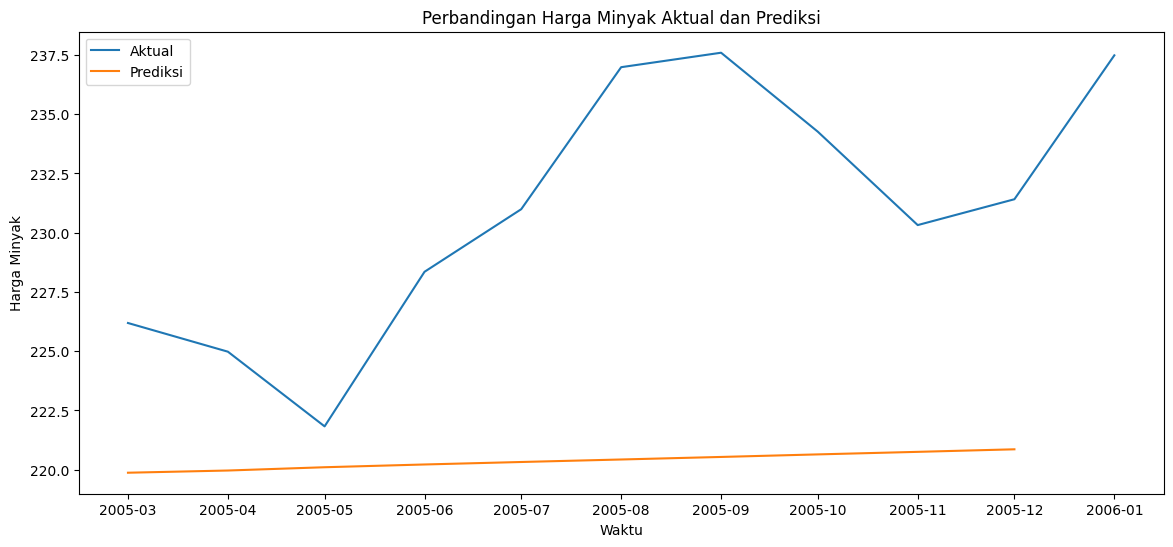

In [618]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Waktu'], combined_df['Aktual'], label='Aktual')
plt.plot(combined_df['Waktu'], combined_df['Prediksi'], label='Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga Minyak')
plt.title('Perbandingan Harga Minyak Aktual dan Prediksi')
plt.legend()
plt.show()


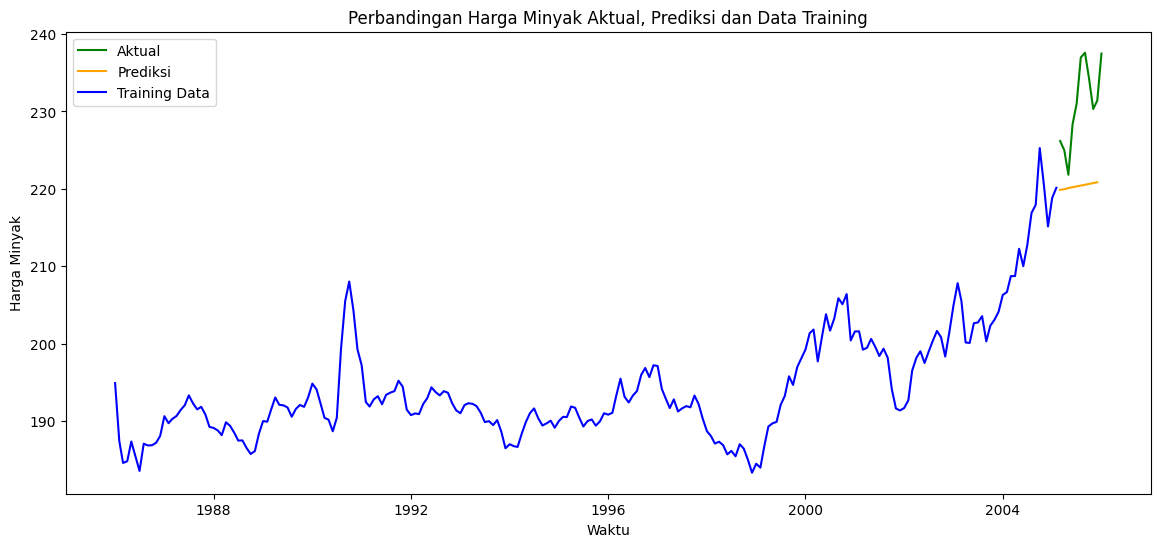

In [619]:
# Plotting with Training Data
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Waktu'], combined_df['Aktual'], label='Aktual', color='green')
plt.plot(combined_df['Waktu'], combined_df['Prediksi'], label='Prediksi', color='orange')
plt.plot(train['date'], train['minyak'], label='Training Data', color='blue') #Plot training data
plt.xlabel('Waktu')
plt.ylabel('Harga Minyak')
plt.title('Perbandingan Harga Minyak Aktual, Prediksi dan Data Training')
plt.legend()
plt.show()


Berdasarkan plot di atas, garis hijau yang merupakan data prediksi tidak sepenuhnya menangkap pola data aktual testing.

# Akurasi

In [620]:
# Calculate MAPE
mape = np.mean(np.abs((test['minyak'] - predictions_inversed) / test['minyak'])) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 4.27%


Model ARIMA (2,1,0) adalah model terbaik dalam memprediksi harga minyak di USD dengan nilai MAPE (Mean Absolute Percentage Error) sebesar 4.27% menunjukkan bahwa model cukup akurat dalam memprediksi harga minyak, karena MAPE < 5% umumnya dianggap sebagai prediksi yang sangat baik,namun model ARIMA(2,1,0) belum mampu menangkap pola lonjakan yang tinggi.